# Assignment 1c Notebook
This notebook builds on the EA code you wrote in Assignment 1b to guide you through implementing two constraint satisfaction EAs. Therefore, you should copy over the following files:
* `base_evolution.py`
* `linear_genotype.py`
* `selection.py`

We also recommend that you copy over your 1a and 1b notebooks, data, configs, and your `base_population_evaluation` function in `stock_population_evaluation.py` (though **not** the rest of the file). *Be careful* to not copy over anything else (files you shouldn't have modified anyways). We may have changed them and we want you to have the versions that were provided with this assignment's repo, not the old versions.

Recall that you should be launching this notebook using the `EC-env` conda environment. If you are not in the `EC-env` environment, terminate the notebook server, activate the environment with `conda activate EC-env`, and restart the notebook server.

As usual, be sure to **read all of this notebook**. Start by executing the next cell.

In [1]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

!pip install snake-eyes-parser
!pip install pytest

import warnings
warnings.filterwarnings('ignore') # hopefully stop any pedantic warnings

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

import os
import statistics
from snake_eyes import read_config
from linear_genotype import LinearGenotype
from base_evolution import BaseEvolutionPopulation
from cutting_stock.fitness_functions import unconstrained_fitness_function
from stock_population_evaluation import unconstrained_population_evaluation
from log_analyzer import analyze_constraint_satisfaction_log, format_log
from selection import *
from multiprocessing import Pool

from search_runner import constraint_satisfaction_EA_search

print('The first cell has been executed!')

The first cell has been executed!


## Experimental Changes
You *may* have found during Assignment 1b that your EA solved the problem near-optimally, though this depends a lot on your chosen parameters and your mutation operator; don't feel bad if your EA didn't reach that level of performance. For this assignment, we're providing you with a substantially harder problem instance to demonstrate the performance improvement that constraint satisfaction can provide. We're also lowering the evaluation count for each run by an order of magnitude (down to 100,000) in order to lower the computational burden of this assignment, and to make the problem even harder for your EAs.

Unfortunately, this invalidates comparisons between your 1b EA's results and your results in this assignment. We also can't ask you to simply run your 1b EA on the harder problem instance, since you tuned the parameters specifically for the previous instance. Instead, we're providing you with sample data for comparison. This data was generated using the EA one of your classmates submitted for Assignment 1b, which we (slightly) tuned for the new problem instance. This data (found in `data/1c/base_statistics.txt`) will be loaded by the cells that conduct statistical analysis later in the notebook.

## Cutting Stock Constraints: Boundaries and Overlaps
Some problems, such as the cutting stock problem, have specific criteria (tangential to the main optimization objective) that a solution must obey to be considered valid; these criteria are called *constraints* on the problem. These problems are often described as optimizing for some objective *subject to the constraints*. You may recall from the lectures that there are multiple ways to handle constraints in an EA. You can employ the following techniques:
* kill invalid offspring
* feasible phenotype mapping decoder
* repair function
* feasible solution space closed under variation operators
* assign invalid solutions arbitrarily low fitness
* penalty function
* ignore constraints

In assignments 1a and 1b, we assigned invalid solutions an arbitrarily low fitness. For this assignment, we're going to guide you through the process of implementing another two of these techniques: an EA that ignores the constraints entirely, and an EA using a penalty function. These two techniques embrace the presence of invalid solutions in your EA's population. The first simply ignores that they are invalid, while the second penalizes their fitness based on how much they violate the constraints. Let's review what the constraints are in this assignment series, to understand why keeping invalid solutions around might be useful. As discussed during Assignment 1a, there are two ways for a cutting stock solution to be invalid in our implementation:
1. shapes are out-of-bounds
2. shapes are overlapping

If a solution violates these constraints, it is invalid, as you physically could not cut shapes using such a layout. **Invalid solutions do not actually solve the problem, meaning they are always worse than any valid solution when it finally comes time to cut shapes out of stock**. Therefore, in 1a and 1b, we assigned invalid solutions a manually-defined (and very poor) fitness, chosen to ensure valid solutions were always given priority. Despite this, intuitively, not all invalid solutions are equally good or bad: some may have fewer violations, or occupy a smaller length of stock, than others.

Consider the following solutions to a cutting stock problem:

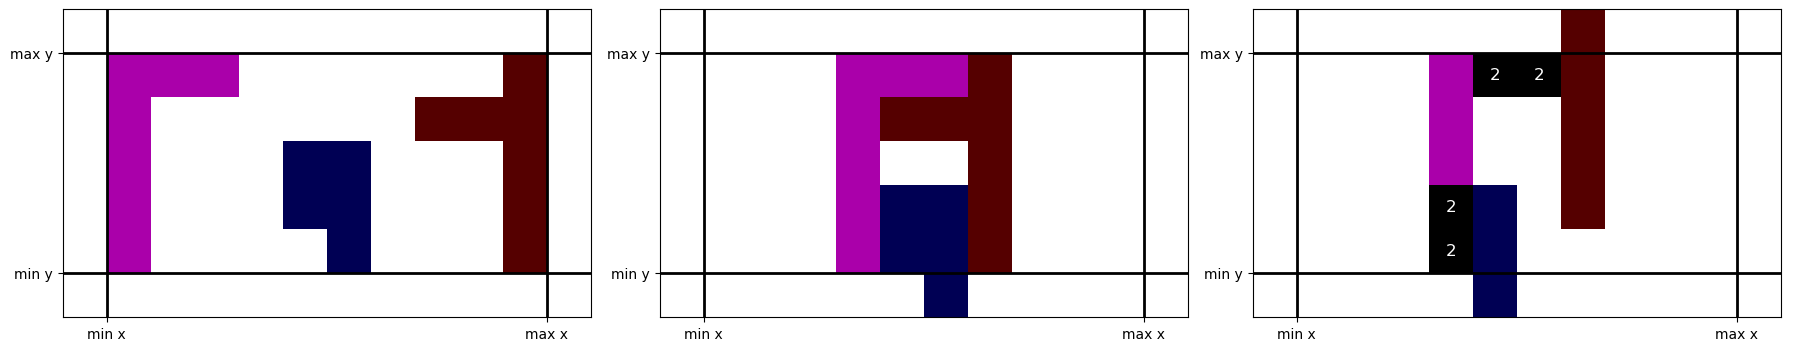

The first solution, being the only valid one, would have had the highest fitness out of these three in assignments 1a and 1b. The second solution is clearly much closer to an optimal solution, yet it would have had an arbitrarily poor fitness because one cell is out-of-bounds (making it invalid). The third solution, though it occupies the same length of stock as the second, is blatantly worse because it has more violations. Despite this, they would have both had the same fitness. Clearly, it's possible to assign meaningful fitness values to invalid solutions, allowing us to compare them (to valid solutions and to other invalid solutions), even though our previous definition of fitness failed to do so. 

To reiterate, if you had to use one of these examples as a solution, *without making any changes*, the only correct choice is the first one; the other two are invalid and do not actually solve the problem. However, if you had to use one of these examples *as a template for making new solutions*, then the second example is probably the best. Of these three, it is the closest one in the search landscape to optimal **valid** solutions. While it is **not** a valid solution on its own, it is still useful as genetic material in an EA (it would be a very good parent). This introduces a critical idea: there can be a difference between how well a solution actually solves the problem, versus how much we want it to survive and reproduce during a run of our EA!

## unconstrained_fitness_function
In Assignment 1a, you used `base_fitness_function` to evaluate solutions. That function returned a `dict` with two values, namely, a fitness value and a visualization function. The fitness value was the length of stock available minus the length used, unless the solution was invalid, in which case it was an arbitrary negative value (`failure_fitness` in the config).

To properly implement your constraint satisfaction EAs, we will be using `unconstrained_fitness_function`, which has slightly different behavior. You are free to compare and contrast the two functions, located in `cutting_stock/fitness_functions.py`, if you wish. In short, `unconstrained_fitness_function` returns a `dict` with four values:

* `'base fitness'` - The same value as `'fitness'` from `base_fitness_function`: length available minus length used for valid solutions, otherwise `failure_fitness` for invalid solutions. It has simply been renamed to remind you that we will be using it differently (you can't mindlessly reuse your existing code!).
* `'unconstrained fitness'` - The fitness value a solution would have if constraints are ignored: length available minus length used, for all solutions. Obviously, if a solution is valid (i.e., it violates no constraints), this is the same as its base fitness.
* `'violations'` - A nonnegative integer that represents the number of constraint violations in the solution. This is the number of cells that are out-of-bounds, plus the number of overlaps. If a solution is valid, it obviously has zero violations.
* `'visualize'` - The same as before.

The following cell demonstrates how to obtain these values using `unconstrained_fitness_function`:

[(123, 39, 3), (175, 35, 0), (0, 30, 1), (153, 23, 3), (76, 28, 3), (112, 35, 2), (140, 14, 1), (141, 30, 2), (184, 27, 2), (190, 3, 0), (68, 39, 2), (170, 33, 2), (192, 25, 3), (17, 24, 3), (44, 3, 0), (36, 33, 2), (4, 29, 2), (162, 37, 3), (126, 22, 3), (203, 24, 1)]
Base fitness: -50
Violations: 49
Penalized fitness: -63.8
Visualization:


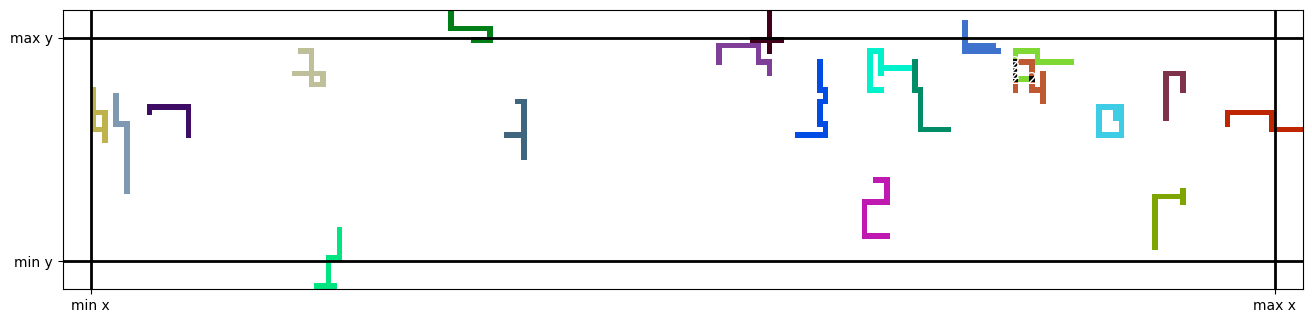

In [2]:
config = read_config('configs/1c_green_penalty_config.txt', globals(), locals())

# Used in calculating some values below; we'll discuss this later.
penalty_coefficient = config['problem']['penalty_coefficient']

# Make a random solution
test_solution = LinearGenotype()
test_solution.random_initialization(**config['problem'])
print(test_solution.genes)

# Evaluate the solution
output = unconstrained_fitness_function(test_solution.genes, **config['problem'])

# Assign member variables based on the evaluation
test_solution.base_fitness = output['base fitness']
test_solution.violations = output['violations']
test_solution.fitness = output['unconstrained fitness'] - test_solution.violations * penalty_coefficient
test_solution.visualize = output['visualize']

# Print statements & visualization for tutorial
print('Base fitness:', test_solution.base_fitness)
print('Violations:', test_solution.violations)
print('Penalized fitness:', test_solution.fitness)
print('Visualization:')
test_solution.visualize()

del config, penalty_coefficient, test_solution, output

Note how we've assigned four member variables:
* `base_fitness` - The same thing as plain-old fitness from 1a and 1b, but we can think about it in a new way: `base_fitness` is how well the solution actually solves the problem, **NOT** necessarily how much we want it to survive and reproduce.
* `violations` - The number of constraint violations in the solution.
* `fitness` - The solution's penalized fitness. We calculate and assign `test_solution.fitness` using the solution's unconstrained fitness, its number of constraint violations, and a configured penalty coefficient (more on that in a bit). Since your selection algorithms were written to use each individual's `fitness` member variable, this is the variable that will actually affect your EA's search. In other words: `fitness` now represents how much we want an individual to survive and reproduce, **NOT** necessarily how well it actually solves the problem.
* `visualize` - The same as before.

To be abundantly clear: **it is invalid to directly compare different types of fitness in your statistical analysis!** We will discuss this in more detail later in the notebook. For now, just know that storing all these different values in your individuals will make analysis more intuitive later on.

Now, let's look at how `fitness` was calculated: `unconstrained_fitness - violations * penalty_coefficient`. We are taking `unconstrained_fitness` (a solution's fitness if we ignore the constraints), and subtracting a penalty from it. This is why we say we are using a "penalty function", and why we call the new `fitness` a solution's "penalized fitness". The penalty is calculated as `violations * penalty_coefficient`, i.e., the number of times a solution violated the constraints multiplied by a (configurable) coefficient.

The choice of penalty coefficient is very important, since it lets us fine-tune how severely a solution is penalized for each violation. If it's too high, then an EA may behave similarly to Assignment 1b: it would strongly prefer valid solutions over invalid solutions. If it's too low, then the EA might stop generating valid solutions entirely, as it converges to an optimum in invalid solution space. If the penalty coefficient is zero, then the EA entirely ignores the constraints. You might recall we told you that you will be implementing two techniques for constraint satisfaction: ignoring the constraints and a penalty function. These actually have the same implementation, with the only difference being that the first has the penalty coefficient set to zero, while the second has a positive penalty coefficient.

Now that we've demonstrated how to calculate these values, it's your turn to write a function that evaluates an input population and assigns the above members to each individual. Complete the `unconstrained_population_evaluation` function inside `stock_population_evaluation.py`. This function should be pretty similar to the `base_population_evaluation` function you wrote for Assignment 1b, but notice the addition of the `penalty_coefficient` parameter.

Average penalized fitness of population: -38.452999999999996
Best penalized fitness in population: 62.0
Average base fitness of population: -49.9753
Best base fitness in population: 18
Number of valid solutions: 4
Visualizing solution with best penalized fitness and solution with best base fitness:


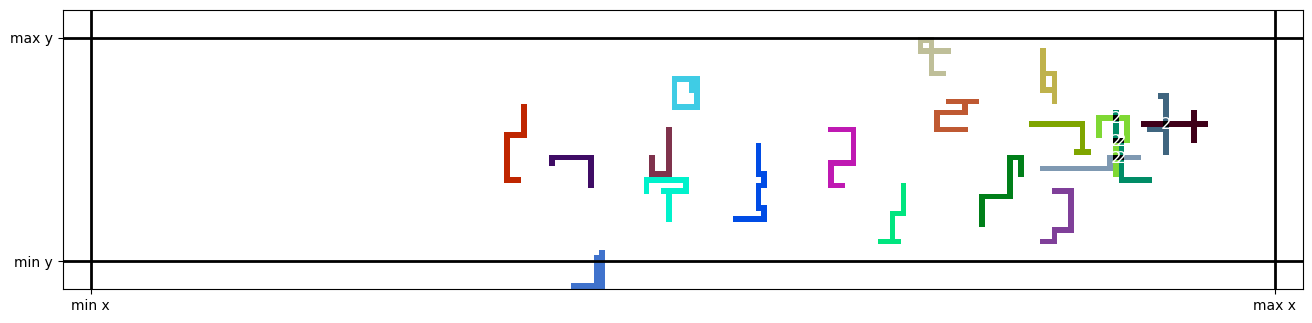

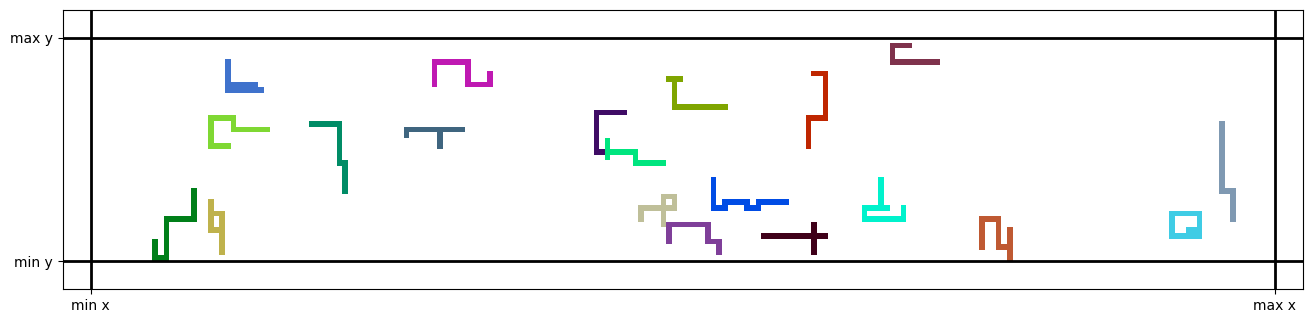

In [3]:
config = read_config('configs/1c_green_penalty_config.txt', globals(), locals())

example_population = LinearGenotype.initialization(10000, **config['problem'])

# Note explicitly initializing to None is unnecessary in general
# We only do it here to test that you've actually set these values
for individual in example_population:
    individual.base_fitness = None
    individual.violations = None
    individual.fitness = None
    individual.visualize = None

# Calling your function to test things out
unconstrained_population_evaluation(example_population, **config['problem'])

no_base = [individual.base_fitness for individual in example_population].count(None)
no_violations = [individual.violations for individual in example_population].count(None)
no_penalized = [individual.fitness for individual in example_population].count(None)
no_visualize = [individual.visualize for individual in example_population].count(None)

failed = no_base or no_violations or no_penalized or no_visualize

if not failed:
    penalized_fitnesses = [individual.fitness for individual in example_population]
    print('Average penalized fitness of population:', statistics.mean(penalized_fitnesses))
    print('Best penalized fitness in population:', max(penalized_fitnesses))

    base_fitnesses = [individual.base_fitness for individual in example_population]
    print('Average base fitness of population:', statistics.mean(base_fitnesses))
    print('Best base fitness in population:', max(base_fitnesses))
    
    print('Number of valid solutions:', [individual.violations for individual in example_population].count(0))
    
    print('Visualizing solution with best penalized fitness and solution with best base fitness:')
    max(example_population, key=lambda x:x.fitness).visualize()
    max(example_population, key=lambda x:x.base_fitness).visualize()

    del penalized_fitnesses, base_fitnesses

else:
    print('Something was left as None. Ensure the entire population is evaluated then execute this cell again.')
    print('Individuals with unassigned base fitness:', no_base)
    print('Individuals with unassigned violations:', no_violations)
    print('Individuals with unassigned fitness:', no_penalized)
    print('Individuals with unassigned visualize:', no_visualize)

del config, example_population, no_base, no_violations, no_penalized, no_visualize, failed

## Assembling your EA
Now you get to use the framework you implemented in Assignment 1b to build a constraint satisfaction EA! Note that this can be nearly identical to the function from Assignment 1b's notebook, with a couple key differences:
* You should use `unconstrained_population_evaluation` rather than `base_population_evaluation`.
* You should base most of your analysis on the `base_fitness` of your population, instead of the penalized `fitness`, so we have a consistent metric to perform statistical analysis with. That is, your best solution from each run is the one with the global best `base_fitness`, and that `base_fitness` value is the one that should be recorded for statistical analysis.
* You should still record the local average and local best `fitness` of your adult population each generation, in addition to the aforementioned `base_fitness`, for plotting and logging.
* You should also record the proportion of valid solutions in the adult population at each generation. The last line in the below code block contains code to calculate the number of valid solutions; you should record the proportion by dividing this value by the population size.
* Wherever you added to the automated log in 1b (after initial evaluations, and after survival selection; code that looked like `ea.log.append(f'...')`), you should replace it with the following code (which adds a distinction between penalized fitness and base fitness):
```py
ea.log.append(f'Evaluations: {ea.evaluations}')
ea.log.append(f'Local best penalized fitness: {max(map(lambda x:x.fitness, ea.population))}')
ea.log.append(f'Local mean penalized fitness: {statistics.mean(map(lambda x:x.fitness, ea.population))}')
ea.log.append(f'Local best base fitness: {max(map(lambda x:x.base_fitness, ea.population))}')
ea.log.append(f'Local mean base fitness: {statistics.mean(map(lambda x:x.base_fitness, ea.population))}')
ea.log.append(f'Number of valid solutions: {[x.violations for x in ea.population].count(0)}')
```
Note you'll want to name your `BaseEvolutionPopulation` variable `ea`, or change the variable name in the above code. And, as in 1b, we expect you to implement your own logging in addition to your EA's `log` member that we create for you.

Implement your constraint satisfaction EA in the following cell. Remember to return data from the function as necessary, including your `BaseEvolutionPopulation`'s `log` member variable. Then run the cell after that to test one run of your penalty function EA!

In [4]:
from search_runner import constraint_satisfaction_EA_search

[(90, 16, 3), (79, 13, 1), (83, 28, 3), (94, 28, 0), (91, 36, 3), (87, 27, 1), (81, 30, 2), (102, 15, 0), (71, 21, 0), (105, 0, 3), (84, 7, 0), (71, 7, 0), (89, 20, 0), (96, 34, 2), (80, 12, 1), (104, 17, 1), (79, 10, 1), (77, 2, 0), (103, 26, 1), (104, 37, 3)]


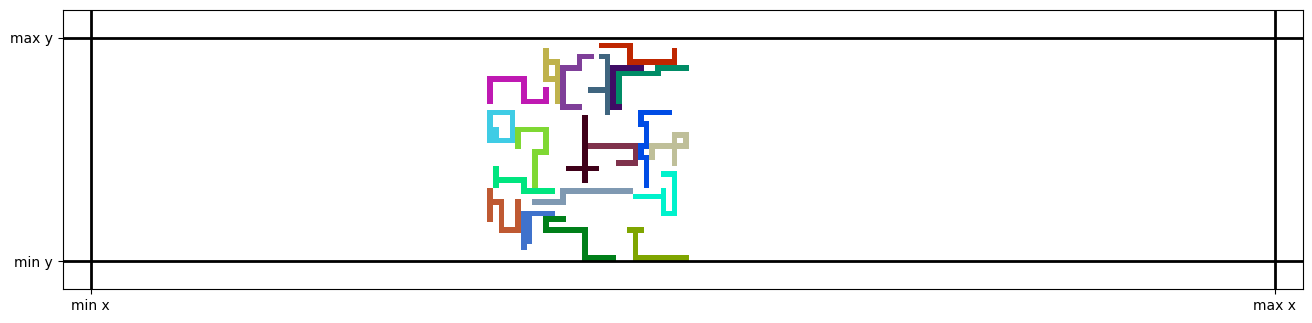

In [6]:
# Testing one run of your penalty function EA
log, data_log, global_base_fittest = constraint_satisfaction_EA_search(100_000, 'configs/1c_green_penalty_config.txt')

# Save the logged values to a file for you to view
# Note that printing the log often fails; too much data all at once
with open('example_log.txt', 'w') as f:
    f.write(format_log(log))

# Print the other outputs
print(global_base_fittest.genes)
global_base_fittest.visualize()

## Tuning
Now that you have a function capable of performing a single run of your EA using a configurable constraint satisfaction approach, you can prepare to perform a pair of 30-run experiments: one using the penalty function (i.e., positive `penalty_coefficient`) and another ignoring the constraints (i.e., zero `penalty_coefficient`). Before the experiment, of course, you should tune your parameters. But first, as part of your grade (under the Report category), we want you to answer the following questions before you conduct your tuning:

1. In Assignment 1b, you most likely needed to increase $\mu$ (`mu`) from its default of 5 to a much larger value. This was partially because of the way your 1b EA handled invalid solutions. Why does assigning invalid solutions an arbitrarily low fitness (as in Assignment 1b) make it a bad idea to use such a small value for $\mu$ on our cutting stock problem instances?
    * Hint: Think about your initial population. For example, as discussed above, we ran a 1b EA on the new problem instance. We ran that EA with $\mu$ set to 25,000 (**not** an example of a good value for 1b or 1c). For each run, the number of valid solutions in the initial population were: $[7, 8, 4, 4, 10, 8, 9, 7, 7, 3, 7, 11, 14, 7, 4, 8, 6, 6, 3, 6, 3, 9, 10, 14, 2, 7, 10, 4, 4, 6]$


2. Suppose you set $\mu$ to 900,000 during Assignment 1b. If there are 1,000,000 total evaluations, how many children (i.e., solutions made during `generate_children`) will your EA produce during a run?


3. In question 2, what percentage of your EA's total evaluations would be spent on randomly-initialized individuals?


4. Does your answer to question 3 highlight a problem caused by setting $\mu$ to such a high value? If so, what is the problem?


5. Do the changes we have made to our definition of fitness in Assignment 1c make smaller values of $\mu$ more reasonable? If so, why?

### Write your answers in this markdown cell.

1. Because invalid solutions were punished equally, we needed a large $\mu$ to ensure a sufficient amount of genetic diversity in the initial population. With a small $\mu$, it is relatively likely that all randomly generated individuals in the initial population are invalid, or only a few valid solutions exist. Those solutions' gene would dominate the mating pool for the whole run  

2. If the initial population size is 900,000, then we use 900,000 evaluations on that initial populatin, leaving us with 100,000 to use on children. Therefore, we would generate 100,000 children.  

3. Since we have 900,000 randomly generated individuals and 1,000,000 evaluations, then we spend $\frac{900,000}{1,000,000} = 90\%$ of the evaluations on randomly initialized individuals.

4. For this problem, there is a lot of value in combining and mutating decent solutions to produce better ones. When we spend so much of the time on random individuals, we waste time we could be using on children that recombine and mutate decent parents. We don't many generations to try to exploit knowledge encoded in those individuals.   

5. With invalid individuals now being ranked proportional to _how_ invalid they are, there is now some value in keeping those invidiuals in the population. There's an example earlier in this notebook that shows that visually. Therefore, we don't need to randomly generate as many individuals at the beginning of the run, since the genetic diversity in the invalid solutions are now helpful, and we don't have to wait for random generation to yield valid individuals.  


Now, tune the parameters in `1c_green_penalty_config.txt` (including `penalty_coefficient`)  and `1c_green_ignore_config.txt` (which should leave `penalty_coefficient` at 0). You may use your tuned parameters from Assignment 1b as a starting point, but recall that we lowered the evaluation limit to a tenth of what it was there. For this assignment, we require that you tune your penalty function EA such that it outperforms our sample data by a statistically significant margin. We have no requirement for the EA that ignores the constraints, though you are still expected to explore parameter modifications at least a little bit using the following cells.

Note that the penalty coefficient can be any positive real number. If you want to use a non-integer coefficient, we strongly recommend writing it as a rational fraction: you should use `1/3` rather than `0.333333`, to help avoid floating-point errors.

In [4]:
tuning_runs = 8
number_evaluations = 100_000
config_filename = 'configs/1c_green_penalty_config.txt'

def one_run(i):
    log, data_log, global_base_fittest = constraint_satisfaction_EA_search(number_evaluations, config_filename)
    print(f"Run {i}: {global_base_fittest.base_fitness}")
    return (log, data_log, global_base_fittest.genes, global_base_fittest.base_fitness)

os.makedirs('data/1c/green/penalty/tuning/', exist_ok=True)
with Pool() as pool:
    res = pool.map(one_run, range(tuning_runs))

res = list(res)
for i in range(len(res)):
    log, data_log, best_genes, best_base_fitness = res[i]
    with open(f'data/1c/green/penalty/tuning/{i+1}_data.txt', 'w') as f:
        f.write(f"{best_base_fitness}\n")
        f.write(f"{best_genes}\n")
        f.write('\n'.join(data_log))

Run 0: 180
Run 2: 176
Run 7: 175
Run 1: 172
Run 6: 170
Run 3: 165
Run 5: 174
Run 4: 173


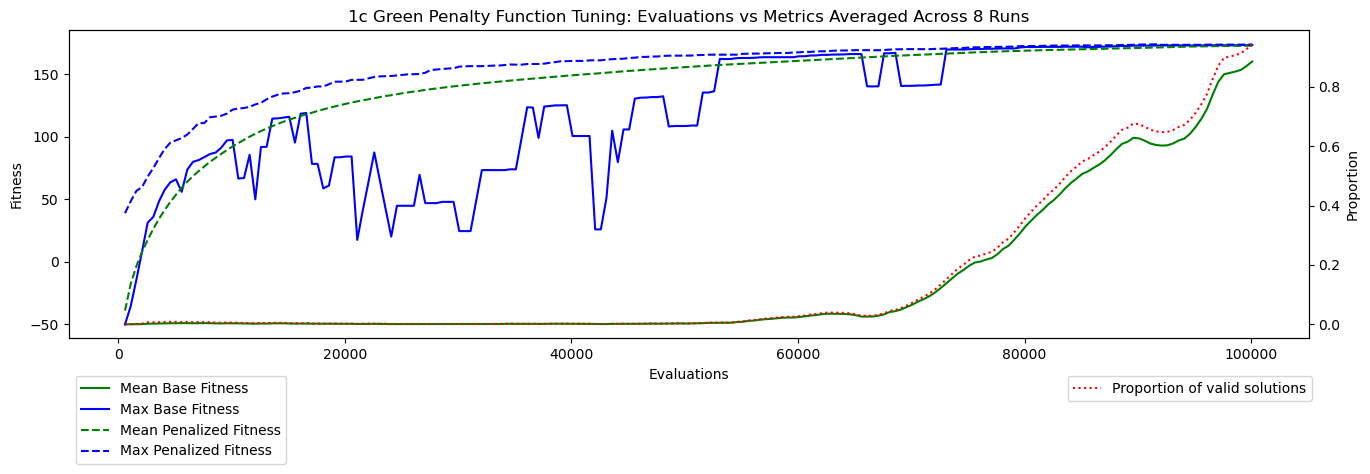

Best fitness: 180


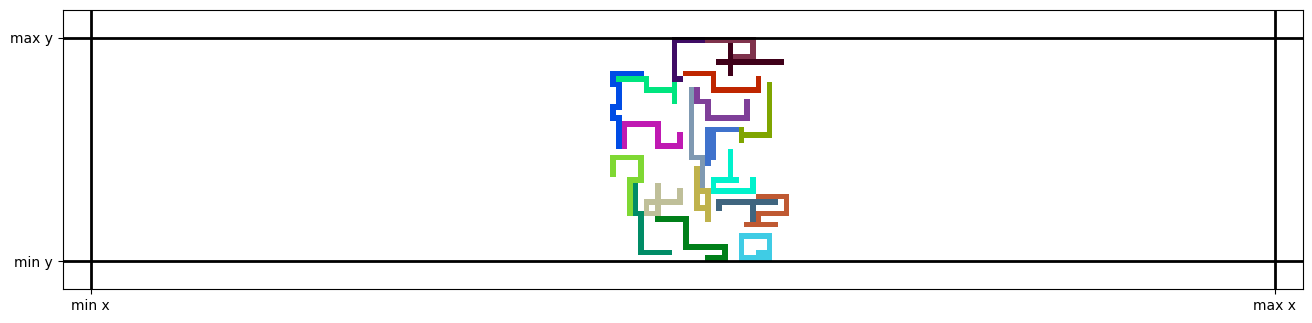

In [5]:
from data_log_parser import load_average_data_logs
filenames = [f'data/1c/green/penalty/tuning/{i+1}_data.txt' for i in range(tuning_runs)]
res = load_average_data_logs(filenames)
overall_best_individual, evals, average_penalized_maxes, average_penalized_means, average_base_maxes, average_base_means, average_valid_proportion = res

fig, ax = plt.subplots()

ax.set(xlabel = 'Evaluations', title = f'1c Green Penalty Function Tuning: Evaluations vs Metrics Averaged Across {tuning_runs} Runs')

ax2 = ax.twinx()

ax.plot(evals, average_base_means, 'g-')
ax.plot(evals, average_base_maxes, 'b-')
ax.plot(evals, average_penalized_means, 'g--')
ax.plot(evals, average_penalized_maxes, 'b--')
ax.set(ylabel = 'Fitness')
ax.legend(['Mean Base Fitness', 'Max Base Fitness', 'Mean Penalized Fitness', 'Max Penalized Fitness'],\
          loc = 'upper left', bbox_to_anchor = (0, -0.1))

ax2.plot(evals, average_valid_proportion, 'r:')
ax2.set(ylabel = 'Proportion')
ax2.legend(['Proportion of valid solutions'],\
           loc = 'upper left', bbox_to_anchor = (0.8, -0.1))

plt.show()

config = read_config(config_filename, globals(), locals())
evaluation = unconstrained_fitness_function(overall_best_individual.genes, **config['problem'])
evaluation['visualize']()
print("Best fitness:",overall_best_individual.base_fitness)

In [8]:
tuning_runs = 8
number_evaluations = 100_000
config_filename = 'configs/1c_green_ignore_config.txt'

def one_run(i):
    log, data_log, global_base_fittest = constraint_satisfaction_EA_search(number_evaluations, config_filename)
    print(f"Run {i}: {global_base_fittest.base_fitness}")
    return (log, data_log, global_base_fittest.genes, global_base_fittest.base_fitness)

os.makedirs('data/1c/green/ignore/tuning/', exist_ok=True)
with Pool() as pool:
    res = pool.map(one_run, range(tuning_runs))

res = list(res)
for i in range(len(res)):
    log, data_log, best_genes, best_base_fitness = res[i]
    with open(f'data/1c/green/ignore/tuning/{i+1}_data.txt', 'w') as f:
        f.write(f"{best_base_fitness}\n")
        f.write(f"{best_genes}\n")
        f.write('\n'.join(data_log))

Run 7: 58
Run 5: 62
Run 2: 83
Run 6: 60
Run 0: 52
Run 4: 64
Run 3: 71
Run 1: 23


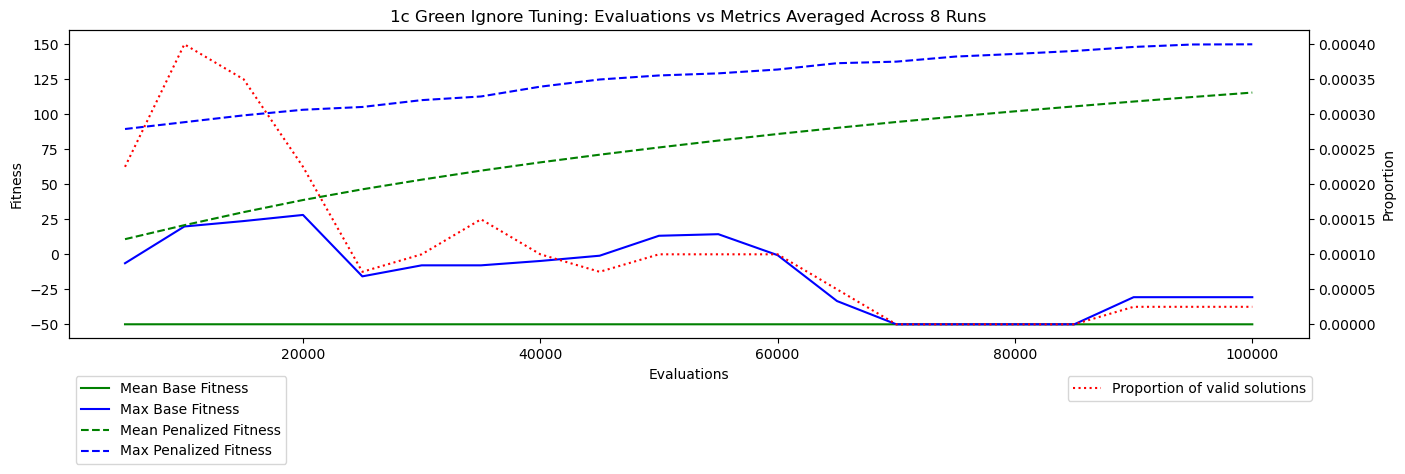

Best fitness: 105


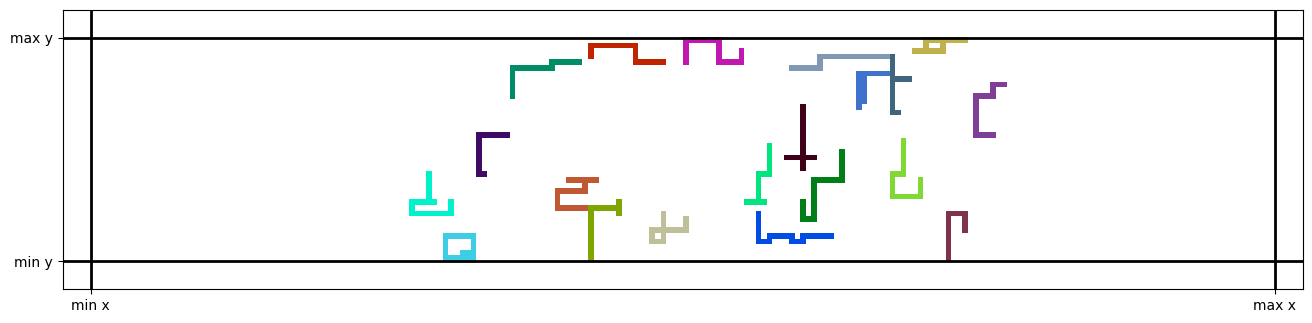

In [7]:
from data_log_parser import load_average_data_logs
filenames = [f'data/1c/green/ignore/tuning/{i+1}_data.txt' for i in range(tuning_runs)]
res = load_average_data_logs(filenames)
overall_best_individual, evals, average_penalized_maxes, average_penalized_means, average_base_maxes, average_base_means, average_valid_proportion = res

fig, ax = plt.subplots()

ax.set(xlabel = 'Evaluations', title = f'1c Green Ignore Tuning: Evaluations vs Metrics Averaged Across {tuning_runs} Runs')

ax2 = ax.twinx()

ax.plot(evals, average_base_means, 'g-')
ax.plot(evals, average_base_maxes, 'b-')
ax.plot(evals, average_penalized_means, 'g--')
ax.plot(evals, average_penalized_maxes, 'b--')
ax.set(ylabel = 'Fitness')
ax.legend(['Mean Base Fitness', 'Max Base Fitness', 'Mean Penalized Fitness', 'Max Penalized Fitness'],\
          loc = 'upper left', bbox_to_anchor = (0, -0.1))

ax2.plot(evals, average_valid_proportion, 'r:')
ax2.set(ylabel = 'Proportion')
ax2.legend(['Proportion of valid solutions'],\
           loc = 'upper left', bbox_to_anchor = (0.8, -0.1))

plt.show()

config = read_config(config_filename, globals(), locals())
evaluation = unconstrained_fitness_function(overall_best_individual.genes, **config['problem'])
evaluation['visualize']()
print("Best fitness:",overall_best_individual.base_fitness)

## Experiment
Now, implement code to perform two experiments: 30 runs of your penalty coefficient EA, and 30 runs of your EA ignoring constraints, with each run performing 100,000 evaluations. Make sure to log data as outlined in the "Assembling your EA" section of this notebook. Visualize the solution from each experiment with the global best base fitness (one visualization from each experiment). Save all experimental data to the `data/1c/green` subdirectory in an easily-understood format. The saved data should be sufficient to recreate your report from scratch. Note that the data stored in your `BaseEvolutionPopulation`'s `log` member is NOT considered sufficient; you should log data separately, in your own format, and save those _in addition to_ the automatic logs.

In [8]:
number_runs = 30
number_evaluations = 100_000
config_filename = 'configs/1c_green_penalty_config.txt'

def one_run(i):
    log, data_log, global_base_fittest = constraint_satisfaction_EA_search(number_evaluations, config_filename)
    print(f"Run {i}: {global_base_fittest.base_fitness}")
    return (log, data_log, global_base_fittest.genes, global_base_fittest.base_fitness)

os.makedirs('data/1c/green/penalty/logs/', exist_ok=True)
with Pool(processes=16) as pool:
    res = pool.map(one_run, range(number_runs))

res = list(res)
for i in range(len(res)):
    log, data_log, best_genes, best_base_fitness = res[i]
    with open(f'data/1c/green/penalty/logs/{i+1}_data.txt', 'w') as f:
        f.write(f"{best_base_fitness}\n")
        f.write(f"{best_genes}\n")
        f.write('\n'.join(data_log))
    with open(f'data/1c/green/penalty/logs/{i+1}.txt', 'w') as f:
        f.write(format_log(log))

Run 4: 181
Run 3: 177
Run 1: 178
Run 14: 175
Run 0: 172
Run 10: 173
Run 13: 169
Run 5: 173
Run 8: 178
Run 7: 173
Run 2: 178
Run 9: 170
Run 11: 174
Run 12: 173
Run 6: 178
Run 15: 178
Run 17: 176
Run 16: 177
Run 20: 179
Run 21: 174
Run 23: 173
Run 25: 171
Run 18: 173
Run 26: 173
Run 19: 174
Run 28: 172
Run 24: 172
Run 22: 174Run 29: 176

Run 27: 176


In [9]:
stats_data = []
best_genotypes = []
for i in range(number_runs):
    with open(f'data/1c/green/penalty/logs/{i+1}_data.txt','r') as f:
        # the best fitness found is stored on the first line
        max_fit = int(f.readline().strip())
        stats_data.append(max_fit)
        # second line has the genes that created that fitness
        # turns the string into a list, as its printed right for that
        max_gene = eval(f.readline().strip())
        best_genotypes.append(max_gene)
print(f"Best fitness found in index {stats_data.index(max(stats_data))} with value {max(stats_data)}")
# Writing your statistical data to a file

with open('data/1c/green/penalty/statistics.txt', 'w') as f:
    for result in stats_data:
        f.write(str(result) + '\n')

# Write the best gene data to a file
with open('data/1c/green/penalty/best_genes.txt', 'w') as f:
    best_idx = stats_data.index(max(stats_data))
    f.write(str(best_genotypes[best_idx]) + "\n")        


Best fitness found in index 4 with value 181


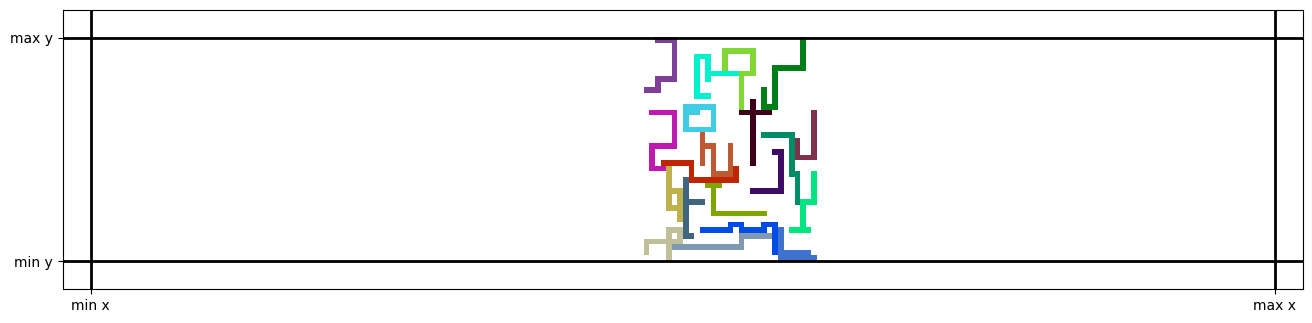

In [10]:
config_filename = 'configs/1c_green_penalty_config.txt'
config = read_config(config_filename, globals(), locals())

#visualize best gene
with open('data/1c/green/penalty/best_genes.txt', 'r') as f:
    best_gene = eval(f.readline().strip())
    output = unconstrained_fitness_function(best_gene, **config['problem'])
    output['visualize']()

In [12]:
number_runs = 30
number_evaluations = 100_000
config_filename = 'configs/1c_green_ignore_config.txt'

def one_run(i):
    log, data_log, global_base_fittest = constraint_satisfaction_EA_search(number_evaluations, config_filename)
    print(f"Run {i}: {global_base_fittest.base_fitness}")
    return (log, data_log, global_base_fittest.genes, global_base_fittest.base_fitness)

os.makedirs('data/1c/green/ignore/logs/', exist_ok=True)
with Pool(processes=16) as pool:
    res = pool.map(one_run, range(number_runs))

res = list(res)
for i in range(len(res)):
    log, data_log, best_genes, best_base_fitness = res[i]
    with open(f'data/1c/green/ignore/logs/{i+1}_data.txt', 'w') as f:
        f.write(f"{best_base_fitness}\n")
        f.write(f"{best_genes}\n")
        f.write('\n'.join(data_log))
    with open(f'data/1c/green/ignore/logs/{i+1}.txt', 'w') as f:
        f.write(format_log(log))

Run 1: 86
Run 14: 43
Run 2: 60
Run 8: 42
Run 7: 111
Run 6: 11
Run 13: 93
Run 3: 69
Run 4: 93
Run 11: 77
Run 5: 64
Run 15: 87
Run 10: 94
Run 0: 50
Run 9: 82
Run 12: 64
Run 16: 55
Run 18: 62
Run 17: 80
Run 20: 58
Run 19: 15
Run 24: 71
Run 27: 46
Run 21: 68
Run 22: 64
Run 23: 90
Run 25: 65
Run 28: 67
Run 26: 97
Run 29: 34


In [13]:
stats_data = []
best_genotypes = []
for i in range(number_runs):
    with open(f'data/1c/green/ignore/logs/{i+1}_data.txt','r') as f:
        # the best fitness found is stored on the first line
        max_fit = int(f.readline().strip())
        stats_data.append(max_fit)
        # second line has the genes that created that fitness
        # turns the string into a list, as its printed right for that
        max_gene = eval(f.readline().strip())
        best_genotypes.append(max_gene)
print(f"Best fitness found in index {stats_data.index(max(stats_data))} with value {max(stats_data)}")
# Writing your statistical data to a file

with open('data/1c/green/ignore/statistics.txt', 'w') as f:
    for result in stats_data:
        f.write(str(result) + '\n')

# Write the best gene data to a file
with open('data/1c/green/ignore/best_genes.txt', 'w') as f:
    best_idx = stats_data.index(max(stats_data))
    f.write(str(best_genotypes[best_idx]) + "\n")        


Best fitness found in index 7 with value 111


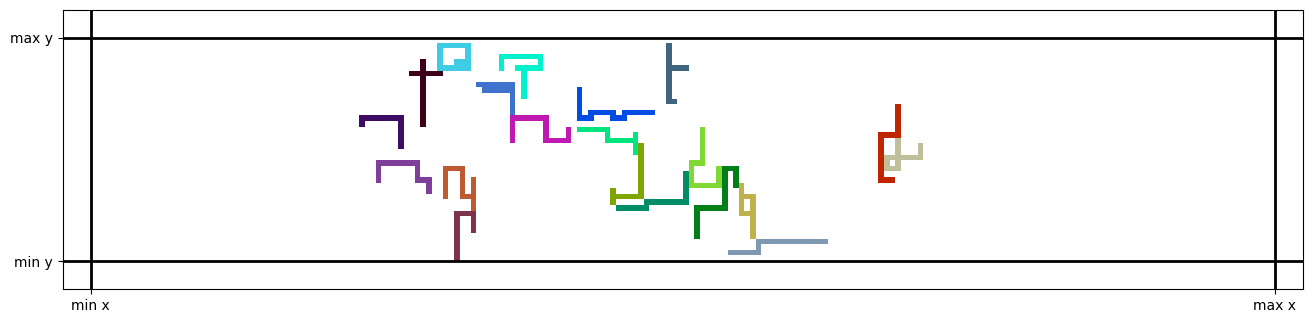

In [14]:
config_filename = 'configs/1c_green_ignore_config.txt'
config = read_config(config_filename, globals(), locals())

#visualize best gene
with open('data/1c/green/ignore/best_genes.txt', 'r') as f:
    best_gene = eval(f.readline().strip())
    output = unconstrained_fitness_function(best_gene, **config['problem'])
    output['visualize']()

## Report
Now you have the data required to complete the report described in the assignment document. There are components of the report you need to complete independently, but this notebook will walk you through generating the plots and conducting statistical analysis.

### Statistical Analysis
Statistical analysis should consist of a comparison between best per-run fitness values of your Assignment 1c EA searches with the data we've provided. You can run the below cells and interpret the results as you did in the previous assignment. Recall that we specify $\alpha=0.05$ for this course. However, since there are multiple tests here, you should use a value of $\alpha=0.05/num\_tests$ for each individual test (i.e., we are applying a Bonferroni correction).

And, as a reminder, **make sure your 1c statistical data is the global best `base_fitness` from each run**.

In [15]:
import statistics
from scipy import stats

# Reading the provided sample data
with open('data/1c/base_statistics.txt', 'r') as f:
    ea_data = [int(line) for line in f.readlines()]

print('Sample data mean:', statistics.mean(ea_data))
print('Sample data stdv:', statistics.stdev(ea_data))
print()

# Reading the data from your 1c penalty function experiment
with open('data/1c/green/penalty/statistics.txt', 'r') as f:
    penalty_data = [int(line) for line in f.readlines()]

print('1c penalty data mean:', statistics.mean(penalty_data))
print('1c penalty data stdv:', statistics.stdev(penalty_data))

penalty_test_result = stats.ttest_ind(ea_data, penalty_data, equal_var=False)
print('p-value (penalty function vs sample):', penalty_test_result.pvalue)
print()

# Reading the data from your 1c ignore constraints experiment
with open('data/1c/green/ignore/statistics.txt', 'r') as f:
    ignore_data = [int(line) for line in f.readlines()]

print('1c ignore data mean:', statistics.mean(ignore_data))
print('1c ignore data stdv:', statistics.stdev(ignore_data))

ignore_test_result = stats.ttest_ind(ea_data, ignore_data, equal_var=False)
print('p-value (ignore constraints vs sample):', ignore_test_result.pvalue)

Sample data mean: 92.7
Sample data stdv: 10.269304781223273

1c penalty data mean: 174.66666666666666
1c penalty data stdv: 2.880772565599833
p-value (penalty function vs sample): 1.2987020797265656e-30

1c ignore data mean: 66.6
1c ignore data stdv: 23.420592177206675
p-value (ignore constraints vs sample): 1.8131463766818632e-06


### Evals-vs-fitness Plot
Using the data you've collected from your two experiments, calculate per-generational values averaged across the 30 runs in each experiment, similar to what you did in Assignment 1b, for each of the following:
* local mean base fitness of adult population
* local max base fitness of adult population
* local mean penalized fitness of adult population
* local max penalized fitness of adult population
* proportion of valid solutions in adult population (in the range $[0, 1]$)

Using this data, plot the *number of evaluations* (not generations) versus these values for each experiment. The following cells have code to generate the plots, but you need to calculate and set the x and y values appropriately.

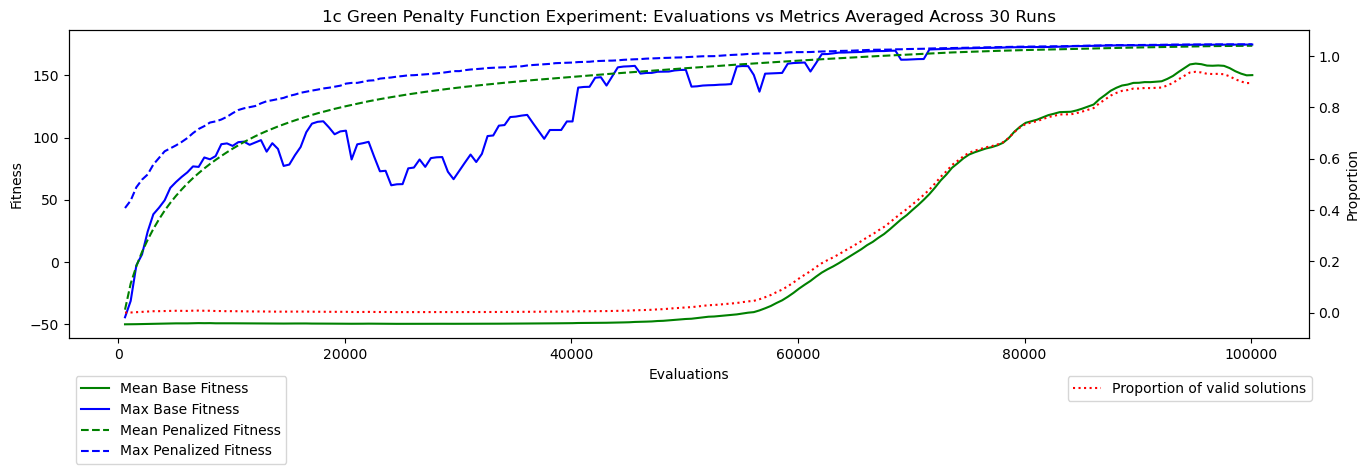

In [4]:
###############################
#                             #
# Penalty function experiment #
#                             #
###############################

from data_log_parser import load_average_data_logs
filenames = [f'data/1c/green/penalty/logs/{i+1}_data.txt' for i in range(number_runs)]
res = load_average_data_logs(filenames)
overall_best_individual, evals, average_penalized_maxes, average_penalized_means, average_base_maxes, average_base_means, average_valid_proportion = res

# save plot data
with open('data/1c/green/penalty/plot_data.txt', 'w') as f:
    for i in range(len(evals)):
        e, avg_pen_max, avg_pen_mean = evals[i], average_penalized_maxes[i], average_penalized_means[i]
        avg_base_max, avg_base_mean, avg_valid_prop = average_base_maxes[i], average_base_means[i], average_valid_proportion[i]
        f.write(f"{e} {avg_pen_max} {avg_pen_mean} {avg_base_max} {avg_base_mean} {avg_valid_prop} \n")

fig, ax = plt.subplots()
ax.set(xlabel = 'Evaluations', title = '1c Green Penalty Function Experiment: Evaluations vs Metrics Averaged Across 30 Runs')

ax2 = ax.twinx()

ax.plot(evals, average_base_means, 'g-')
ax.plot(evals, average_base_maxes, 'b-')
ax.plot(evals, average_penalized_means, 'g--')
ax.plot(evals, average_penalized_maxes, 'b--')
ax.set(ylabel = 'Fitness')
ax.legend(['Mean Base Fitness', 'Max Base Fitness', 'Mean Penalized Fitness', 'Max Penalized Fitness'],\
          loc = 'upper left', bbox_to_anchor = (0, -0.1))

ax2.plot(evals, average_valid_proportion, 'r:')
ax2.set(ylabel = 'Proportion')
ax2.legend(['Proportion of valid solutions'],\
           loc = 'upper left', bbox_to_anchor = (0.8, -0.1))
ax2.set_ylim([-0.1, 1.1])
plt.show()

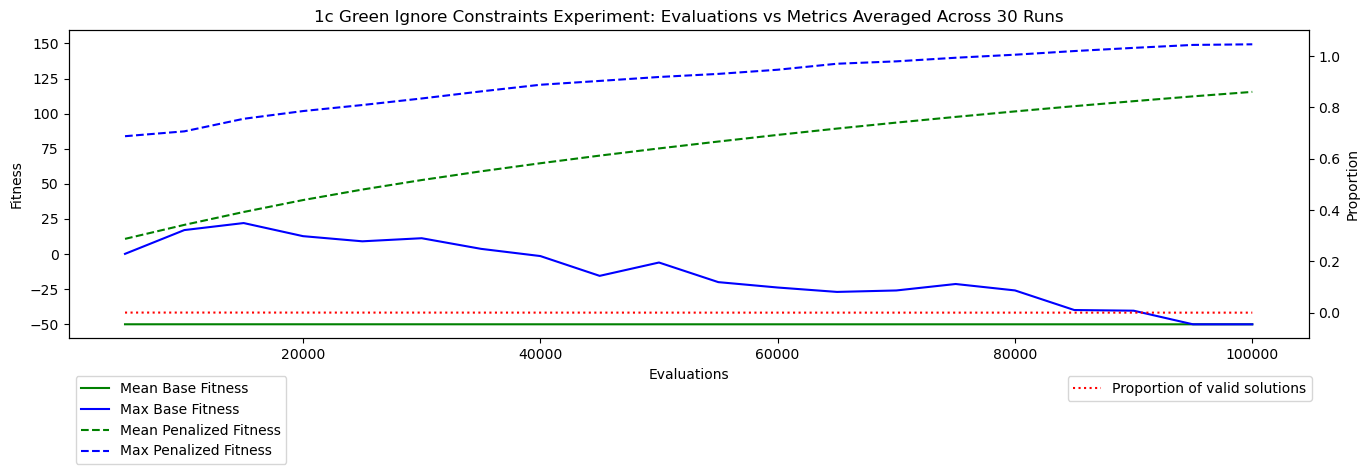

In [5]:
#################################
#                               #
# Ignore constraints experiment #
#                               #
#################################

from data_log_parser import load_average_data_logs
filenames = [f'data/1c/green/ignore/logs/{i+1}_data.txt' for i in range(number_runs)]
res = load_average_data_logs(filenames)
overall_best_individual, evals, average_penalized_maxes, average_penalized_means, average_base_maxes, average_base_means, average_valid_proportion = res

# save plot data
with open('data/1c/green/ignore/plot_data.txt', 'w') as f:
    for i in range(len(evals)):
        e, avg_pen_max, avg_pen_mean = evals[i], average_penalized_maxes[i], average_penalized_means[i]
        avg_base_max, avg_base_mean, avg_valid_prop = average_base_maxes[i], average_base_means[i], average_valid_proportion[i]
        f.write(f"{e} {avg_pen_max} {avg_pen_mean} {avg_base_max} {avg_base_mean} {avg_valid_prop} \n")

fig, ax = plt.subplots()
ax.set(xlabel = 'Evaluations', title = '1c Green Ignore Constraints Experiment: Evaluations vs Metrics Averaged Across 30 Runs')

ax2 = ax.twinx()

ax.plot(evals, average_base_means, 'g-')
ax.plot(evals, average_base_maxes, 'b-')
ax.plot(evals, average_penalized_means, 'g--')
ax.plot(evals, average_penalized_maxes, 'b--')
ax.set(ylabel = 'Fitness')
ax.legend(['Mean Base Fitness', 'Max Base Fitness', 'Mean Penalized Fitness', 'Max Penalized Fitness'],\
          loc = 'upper left', bbox_to_anchor = (0, -0.1))

ax2.plot(evals, average_valid_proportion, 'r:')
ax2.set(ylabel = 'Proportion')
ax2.legend(['Proportion of valid solutions'],\
           loc = 'upper left', bbox_to_anchor = (0.8, -0.1))
ax2.set_ylim([-0.1, 1.1])
plt.show()

# Yellow Deliverable (Bonus for 5660 students, required for 6660 students)
If attempting the 1c yellow deliverable, perform your experiment and analysis below. You may add new cells, if you wish.

## Parameter Tuning

In [7]:
tuning_runs = 8
number_evaluations = 100_000
config_filename = 'configs/1c_yellow_config.txt'

def one_run(i):
    log, data_log, global_base_fittest = constraint_satisfaction_EA_search(number_evaluations, config_filename)
    print(f"Run {i}: {global_base_fittest.base_fitness}")
    return (log, data_log, global_base_fittest.genes, global_base_fittest.base_fitness)

os.makedirs('data/1c/yellow/tuning/', exist_ok=True)
with Pool() as pool:
    res = pool.map(one_run, range(tuning_runs))
# res = [one_run(0)]
res = list(res)
for i in range(len(res)):
    log, data_log, best_genes, best_base_fitness = res[i]
    with open(f'data/1c/yellow/tuning/{i+1}_data.txt', 'w') as f:
        f.write(f"{best_base_fitness}\n")
        f.write(f"{best_genes}\n")
        f.write('\n'.join(data_log))

Run 3: 182
Run 7: 176
Run 6: 180
Run 4: 174
Run 0: 178
Run 5: 180
Run 1: 182
Run 2: 185


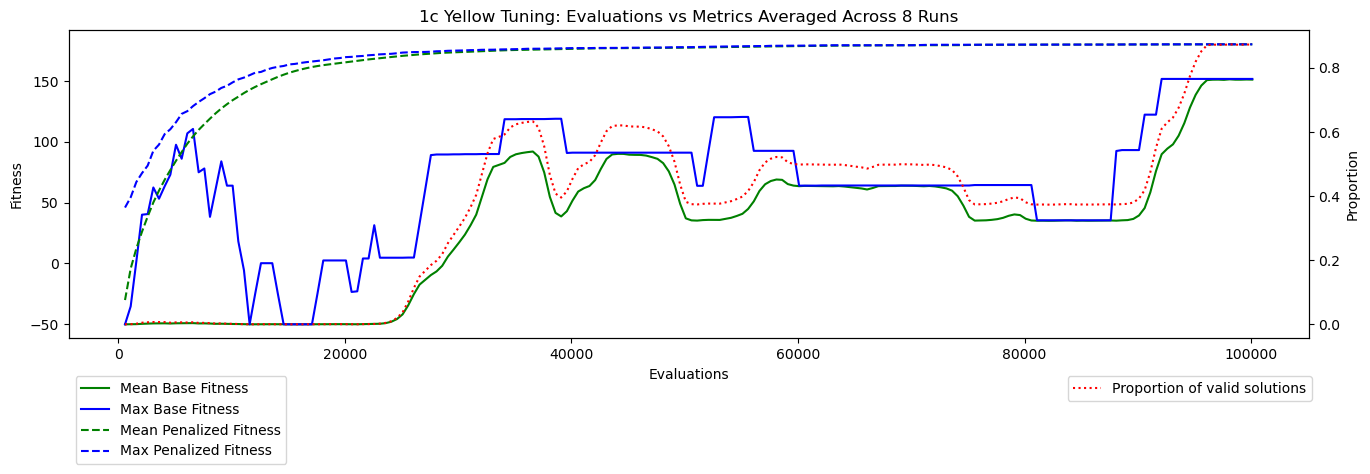

Best fitness: 185


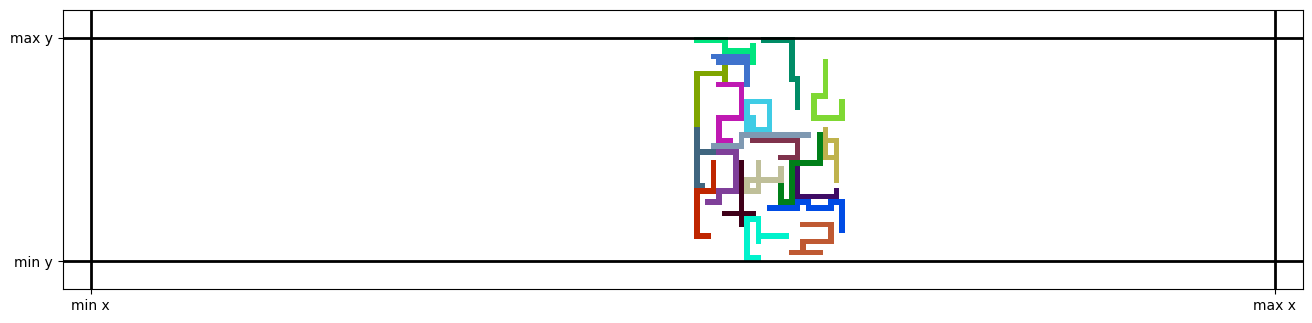

In [16]:
from data_log_parser import load_average_data_logs
filenames = [f'data/1c/yellow/tuning/{i+1}_data.txt' for i in range(tuning_runs)]
res = load_average_data_logs(filenames)
overall_best_individual, evals, average_penalized_maxes, average_penalized_means, average_base_maxes, average_base_means, average_valid_proportion = res

fig, ax = plt.subplots()

ax.set(xlabel = 'Evaluations', title = f'1c Yellow Tuning: Evaluations vs Metrics Averaged Across {tuning_runs} Runs')

ax2 = ax.twinx()

ax.plot(evals, average_base_means, 'g-')
ax.plot(evals, average_base_maxes, 'b-')
ax.plot(evals, average_penalized_means, 'g--')
ax.plot(evals, average_penalized_maxes, 'b--')
ax.set(ylabel = 'Fitness')
ax.legend(['Mean Base Fitness', 'Max Base Fitness', 'Mean Penalized Fitness', 'Max Penalized Fitness'],\
          loc = 'upper left', bbox_to_anchor = (0, -0.1))

ax2.plot(evals, average_valid_proportion, 'r:')
ax2.set(ylabel = 'Proportion')
ax2.legend(['Proportion of valid solutions'],\
           loc = 'upper left', bbox_to_anchor = (0.8, -0.1))

plt.show()

config = read_config(config_filename, globals(), locals())
evaluation = unconstrained_fitness_function(overall_best_individual.genes, **config['problem'])
evaluation['visualize']()
print("Best fitness:",overall_best_individual.base_fitness)

## Experiment

In [17]:
number_runs = 30
number_evaluations = 100_000
config_filename = 'configs/1c_yellow_config.txt'

def one_run(i):
    log, data_log, global_base_fittest = constraint_satisfaction_EA_search(number_evaluations, config_filename)
    print(f"Run {i}: {global_base_fittest.base_fitness}")
    return (log, data_log, global_base_fittest.genes, global_base_fittest.base_fitness)

os.makedirs('data/1c/yellow/logs/', exist_ok=True)
with Pool(processes=16) as pool:
    res = pool.map(one_run, range(number_runs))

res = list(res)
for i in range(len(res)):
    log, data_log, best_genes, best_base_fitness = res[i]
    with open(f'data/1c/yellow/logs/{i+1}_data.txt', 'w') as f:
        f.write(f"{best_base_fitness}\n")
        f.write(f"{best_genes}\n")
        f.write('\n'.join(data_log))
    with open(f'data/1c/yellow/logs/{i+1}.txt', 'w') as f:
        f.write(format_log(log))

Run 6: 173
Run 2: 179
Run 15: 177
Run 3: 180
Run 0: 178
Run 1: 176
Run 7: 179
Run 8: 181
Run 11: 180
Run 4: 179
Run 13: 184
Run 5: 177
Run 9: 181
Run 12: 181
Run 14: 178
Run 10: 178
Run 20: 175
Run 18: 177
Run 16: 179
Run 21: 179
Run 17: 175
Run 25: 175
Run 23: 183
Run 19: 180
Run 27: 180
Run 24: 177
Run 22: 178
Run 29: 182
Run 26: 177
Run 28: 180


In [18]:
stats_data = []
best_genotypes = []
for i in range(number_runs):
    with open(f'data/1c/yellow/logs/{i+1}_data.txt','r') as f:
        # the best fitness found is stored on the first line
        max_fit = int(f.readline().strip())
        stats_data.append(max_fit)
        # second line has the genes that created that fitness
        # turns the string into a list, as its printed right for that
        max_gene = eval(f.readline().strip())
        best_genotypes.append(max_gene)
print(f"Best fitness found in index {stats_data.index(max(stats_data))} with value {max(stats_data)}")
# Writing your statistical data to a file

with open('data/1c/yellow/statistics.txt', 'w') as f:
    for result in stats_data:
        f.write(str(result) + '\n')

# Write the best gene data to a file
with open('data/1c/yellow/best_genes.txt', 'w') as f:
    best_idx = stats_data.index(max(stats_data))
    f.write(str(best_genotypes[best_idx]) + "\n")        


Best fitness found in index 13 with value 184


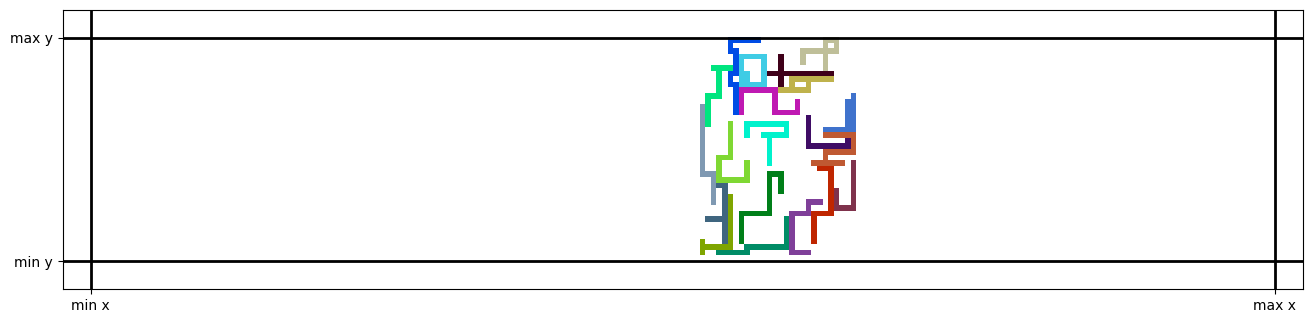

In [19]:
config_filename = 'configs/1c_yellow_config.txt'
config = read_config(config_filename, globals(), locals())

#visualize best gene
with open('data/1c/yellow/best_genes.txt', 'r') as f:
    best_gene = eval(f.readline().strip())
    output = unconstrained_fitness_function(best_gene, **config['problem'])
    output['visualize']()

## Statistical Analysis

In [21]:
import statistics
from scipy import stats

# Reading the provided sample data
with open('data/1c/green/penalty/statistics.txt', 'r') as f:
    green_data = [int(line) for line in f.readlines()]

print('1c Green Fixed Penalty mean:', statistics.mean(green_data))
print('1c Green Fixed Penalty stdv:', statistics.stdev(green_data))
print()

# Reading the data from your 1c penalty function experiment
with open('data/1c/yellow/statistics.txt', 'r') as f:
    yellow_data = [int(line) for line in f.readlines()]

print('1c Yellow adaptive penalty data mean:', statistics.mean(yellow_data))
print('1c Yellow adaptive penalty data stdv:', statistics.stdev(yellow_data))

penalty_test_result = stats.ttest_ind(green_data, yellow_data, equal_var=False)
print('p-value (adaptive penalty vs fixed penalty):', penalty_test_result.pvalue)

1c Green Fixed Penalty mean: 174.66666666666666
1c Green Fixed Penalty stdv: 2.880772565599833

1c Yellow adaptive penalty data mean: 178.6
1c Yellow adaptive penalty data stdv: 2.4858218650634614
p-value (adaptive penalty vs fixed penalty): 5.163126382118084e-07


## Evals vs Fitness Plot

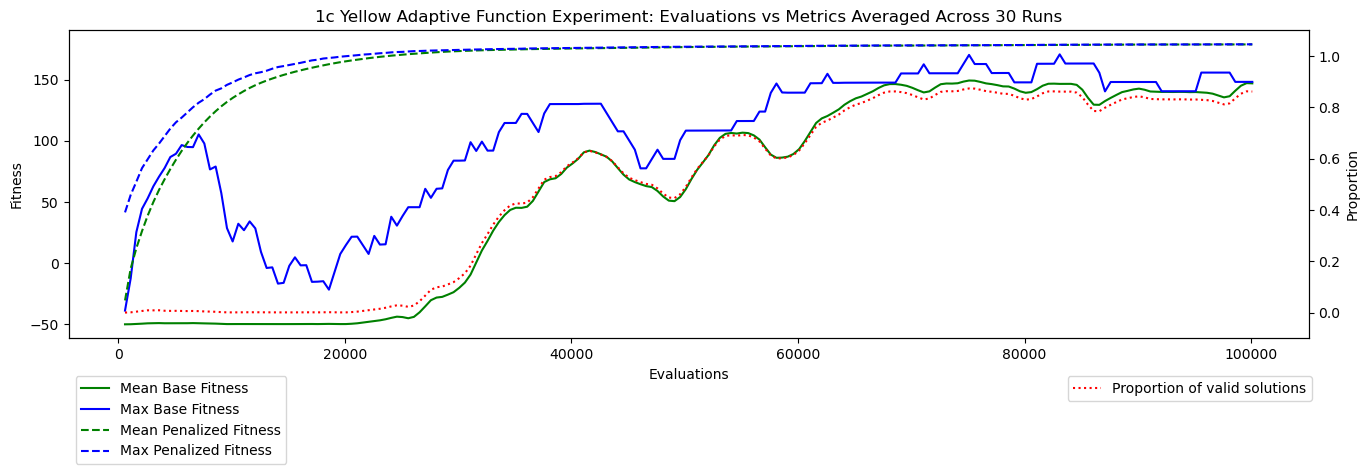

In [6]:
###############################
#                             #
# Yellow experiment           #
#                             #
###############################

from data_log_parser import load_average_data_logs
filenames = [f'data/1c/yellow/logs/{i+1}_data.txt' for i in range(number_runs)]
res = load_average_data_logs(filenames)
overall_best_individual, evals, average_penalized_maxes, average_penalized_means, average_base_maxes, average_base_means, average_valid_proportion = res

# save plot data
with open('data/1c/yellow/plot_data.txt', 'w') as f:
    for i in range(len(evals)):
        e, avg_pen_max, avg_pen_mean = evals[i], average_penalized_maxes[i], average_penalized_means[i]
        avg_base_max, avg_base_mean, avg_valid_prop = average_base_maxes[i], average_base_means[i], average_valid_proportion[i]
        f.write(f"{e} {avg_pen_max} {avg_pen_mean} {avg_base_max} {avg_base_mean} {avg_valid_prop} \n")

fig, ax = plt.subplots()
ax.set(xlabel = 'Evaluations', title = '1c Yellow Adaptive Function Experiment: Evaluations vs Metrics Averaged Across 30 Runs')

ax2 = ax.twinx()

ax.plot(evals, average_base_means, 'g-')
ax.plot(evals, average_base_maxes, 'b-')
ax.plot(evals, average_penalized_means, 'g--')
ax.plot(evals, average_penalized_maxes, 'b--')
ax.set(ylabel = 'Fitness')
ax.legend(['Mean Base Fitness', 'Max Base Fitness', 'Mean Penalized Fitness', 'Max Penalized Fitness'],\
          loc = 'upper left', bbox_to_anchor = (0, -0.1))

ax2.plot(evals, average_valid_proportion, 'r:')
ax2.set(ylabel = 'Proportion')
ax2.legend(['Proportion of valid solutions'],\
           loc = 'upper left', bbox_to_anchor = (0.8, -0.1))
ax2.set_ylim([-0.1, 1.1])
plt.show()

# Red Deliverable (Bonus)
If attempting the 1c red deliverable, perform your experiment and analysis below. You may add new cells, if you wish.